In [1]:
!python -V

Python 3.11.3


In [15]:
import os
import pickle
import pandas as pd
import fastparquet
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
dir_path = '/Users/klemanroy/Github/bootcamps/mlzoomcamp'

## EXPLORATORY DATA ANALYSIS (Actual data)

In [4]:
# TASK: Load the data set
df = pd.read_parquet('/Users/klemanroy/Github/bootcamps/mlzoomcamp/homework/hw1/yellow_tripdata_2022-01.parquet', 
                     engine = 'fastparquet')

In [5]:
# TASK: Determine the data types of the existing data columns
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [7]:
# Number of columns of the dataframe
len(df.columns)

19

In [9]:
# TASK: Add a duration column derived from dropoff and pickup datetime columns
# Specifications:
#      - convert the dropoff_datetime and pickup_datetime columns to datetime type
#      - get tht difference between pickup time and dropoff time in seconds
#      - convert the duration to minutes

# df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
# df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [16]:
# Standard deviation of the duration column
np.std(df.duration)

46.445295712725304

In [17]:
# DESCRIPTION: df.describe() function produces the usual 9-point stat summary for 
# numeric data columns (i.e., count, mean, std, min, P25, P50, P75, max, dtype) and 
# 5-point stat summary for categorical data columns (i.e., count, unique, top, freq, dtype)

# TASKS: additional input is required to add more specific percentile stats (see code below)
# FINDINGS: # at least 98% percent of the duration data have less than 1 hour

df.duration.describe(percentiles = [0.95, 0.98, 0.99])

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
50%      1.018333e+01
95%      3.193333e+01
98%      4.215000e+01
99%      5.085000e+01
max      8.513183e+03
Name: duration, dtype: float64

In [20]:
N = len(df)                                            # 2463931
df = df[(df.duration >= 1) & (df.duration <= 60)]
n = len(df)                                            # 2421440

In [25]:
# Proportion of data left after taking out the outliers
n/N

0.9827547930522406

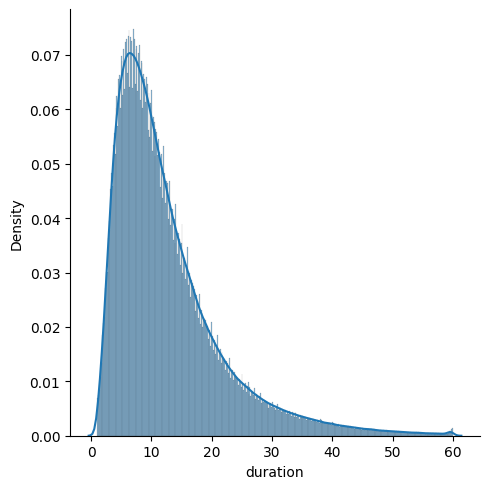

In [26]:
# Plot the distribution of the duration feature
sns.displot(data = df, x = 'duration', kde = True, stat= 'density', kde_kws = dict(cut = 3))

In [30]:
# FUNCTION: read in the data in parquet format
# INPUT: filename (object/str) - the name of the parquet file 
# OUTPUT: df (dataframe) - the processed and subsetted dataframe (based on what was found from the data exploration)
def read_data_parquet(filename):
    # TASK: Load the data
    df = pd.read_parquet(filename, engine = 'fastparquet')
    
    # TASKS: 
    #      1. Add a duration column derived from dropoff and pickup datetime columns
    #      2. Create new LocationID that concatenates PULocationID and DOLocationID
    # Specifications:
    #      1. 
    #      - convert the dropoff_datetime and pickup_datetime columns to datetime type
    #      - get tht difference between pickup time and dropoff time in seconds
    #      - convert the duration to minutes
    #      2. 
    #      - convert the LocationIDs into an object data type
    #      - concatenate the 2 LocationIDs (i.e., PULocationID, DOLocationID)    
    
    # df.tpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    # df.tpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    # TASK: Subset the data to only include durations between 1 minute and 60 minutes, inclusive.
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    return df

In [31]:
# FUNCTION: Further modification of the training and validation datasets that could be useful for building the prediction model.
#           In addition, fit a model and make predictions.
# INPUT: df_train (dataframe) - training dataset
#        df_val (dataframe) - validation/test dataset
#        target (object/str) - prediction variable
#        model_features (object list) - list of column names that will be used as features (independent variables) in building/training the model
#        model (function) - the modeling algorithm/approach that will be used
# OUTPUT: model_output (dict) - consists of X_train, X_val, y_train, y_val, y_pred_train, y_pred_val, dv, model (see descriptions appended below)
def train_model(df_train, df_val, target, model_features, model = LinearRegression()):
    
    # 'Vectorize' the training and the validation datasets
    # 'Vectorize' means transform the lists of feature-value mappings into vectors
    # For more details, visit https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html
    dv = DictVectorizer()
    
    train_dicts = df_train[model_features].to_dict(orient = 'records')
    X_train = dv.fit_transform(train_dicts)

    val_dicts = df_val[model_features].to_dict(orient = 'records')
    X_val = dv.transform(val_dicts)

    y_train = df_train[target].values
    y_val = df_val[target].values

    # Fit the model using the training dataset
    model.fit(X_train, y_train)

    # Predict y values using the fitted model for the training and the validation data
    # The predictions will be used to assess the model and see how well it performs
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    model_output = dict()
    model_output['X_train'] = X_train             # 'Vectorized' training data
    model_output['X_val'] = X_val                 # 'Vectorized' validation data
    
    model_output['y_train'] = y_train             # target data values from the training data
    model_output['y_val'] = y_val                 # target data values from the validation data
    
    model_output['y_pred_train'] = y_pred_train   # predicted y value of the training data
    model_output['y_pred_val'] = y_pred_val       # predicted y value of the validation data

    model_output['dv'] = dv                       # DictVectorizer object (contains various of metedata)
    model_output['model'] = model                 # model object (contains various of metedata)

    return model_output

In [32]:
# TASKS: Load the data sets
df_train = read_data_parquet(dir_path + '/homework/hw1/yellow_tripdata_2022-01.parquet')
df_val = read_data_parquet(dir_path + '/homework/hw1/yellow_tripdata_2022-02.parquet')

## EXPLORATORY DATA ANALYSIS (Processed data)

In [33]:
# TASK: Describe the processed duration column
df_train.duration.describe(percentiles = [0.95, 0.98, 0.99])

count    2.421440e+06
mean     1.267128e+01
std      8.999282e+00
min      1.000000e+00
50%      1.023333e+01
95%      3.105000e+01
98%      3.971667e+01
99%      4.568333e+01
max      6.000000e+01
Name: duration, dtype: float64

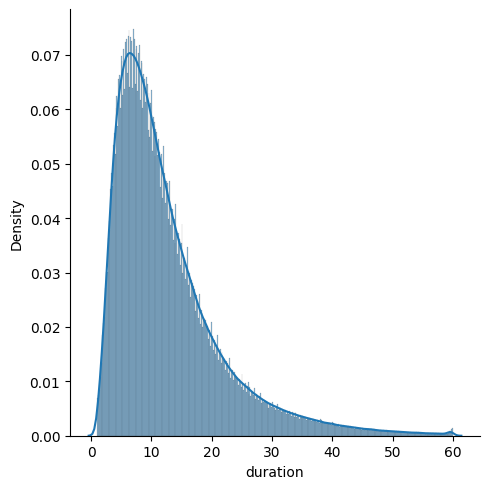

In [34]:
# Plot the distribution of the duration feature
sns.displot(data = df_train, x = 'duration', kde = True, stat= 'density', kde_kws = dict(cut = 3))

## PREDICTION MODELING

The algorithm that shows the lowest mean squared error (MSE) will be our best model.

Note: Will also consider the simplicity of the method (law of parsimony) if the MSEs are pretty close.

In [42]:
categorical = ['PULocationID', 'DOLocationID']
features = categorical

In [ ]:
# Linear Rergression
# CONCLUSION: The best model is Linear Regression due to law or parsimony
lr_model = train_model(df_train, df_val, target = 'duration', model_features = features)

In [44]:
# Get the shape of the X_train after OHE (number of rows by number of columns)
np.shape(lr_model['X_train'])    # No. of rows: 2421440; No. of cols: 515

(2421440, 515)

In [45]:
# Mean squared error on train data
mse_train = mean_squared_error(lr_model['y_train'], lr_model['y_pred_train'], squared = False) 

6.986190833941311

In [46]:
# Mean squared error on validation data
mse_val = mean_squared_error(lr_model['y_val'], lr_model['y_pred_val'], squared = False) 

7.786407054681283

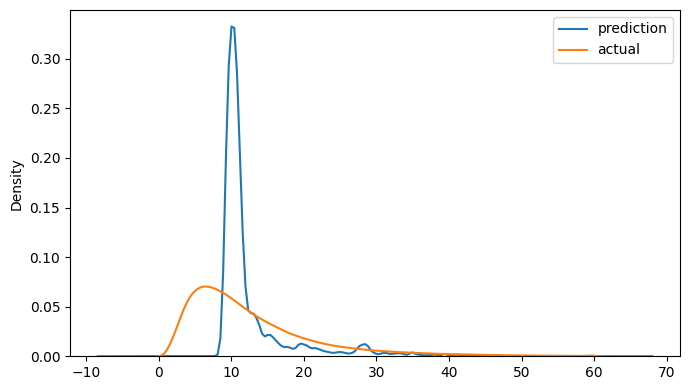

In [48]:
# Compare actual and predicted target variable, duration, using the train data set
fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(lr_model['y_pred_train'], label = 'prediction', ax = ax)
sns.kdeplot(lr_model['y_train'], label = 'actual', ax = ax)

ax.legend()
plt.tight_layout()
plt.show()

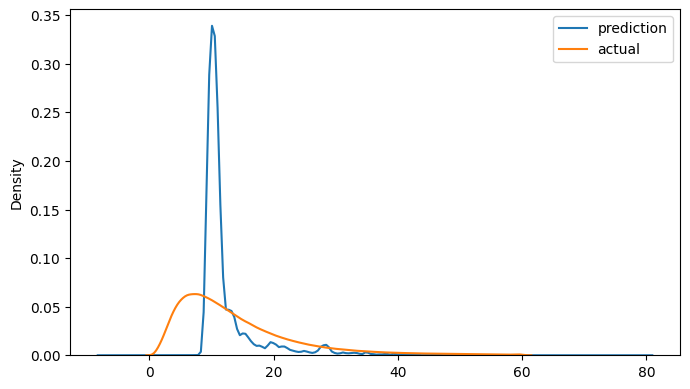

In [47]:
# Compare actual and predicted target variable, duration, using the validation data set
fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(lr_model['y_pred_val'], label = 'prediction', ax = ax)
sns.kdeplot(lr_model['y_val'], label = 'actual', ax = ax)

ax.legend()
plt.tight_layout()
plt.show()